Using transfer learning , perform image classification of yoga poses.  
Pretrained model : VGG16

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import cv2

Read in images with VGG16 preprocessing.

In [2]:
from keras.preprocessing.image import ImageDataGenerator

vgg16_preprocess = tf.keras.applications.vgg16.preprocess_input
##
image_path = "../input/yoga-poses-cgi/train"
test_path = "../input/yoga-poses-cgi/test"
##

train_data_gen = ImageDataGenerator(preprocessing_function = vgg16_preprocess, validation_split = 0.2)
test_data_gen = ImageDataGenerator(preprocessing_function = vgg16_preprocess)


##
train_ds = train_data_gen.flow_from_directory(image_path , target_size=(224, 224),
        batch_size=32 ,subset = 'training' , seed = 123 , class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')
val_ds = train_data_gen.flow_from_directory(image_path , target_size=(224, 224),
        batch_size=32 ,subset = 'validation' , seed = 123 , class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')

test_ds = test_data_gen.flow_from_directory(test_path ,target_size=(224, 224),
        batch_size=32 ,class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


In [3]:
labels = (train_ds.class_indices)
labels_dict = dict((v,k) for k,v in labels.items())
labels_dict

{0: 'chair', 1: 'cobra', 2: 'dog', 3: 'tree', 4: 'warrior'}

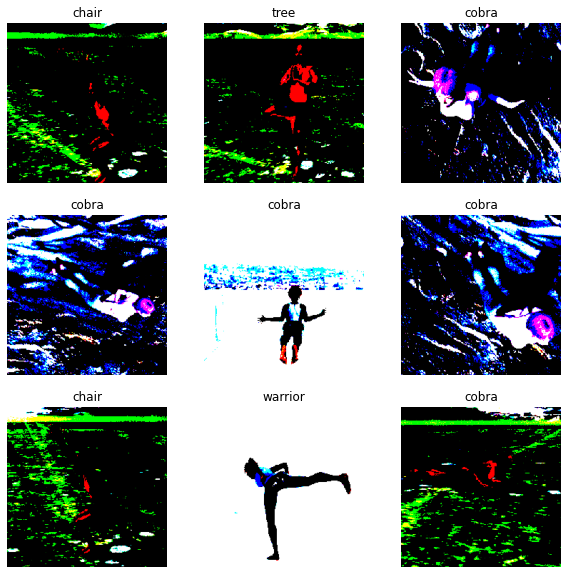

In [4]:
## visualize train set images
image_batch, label_batch = next(iter(train_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")


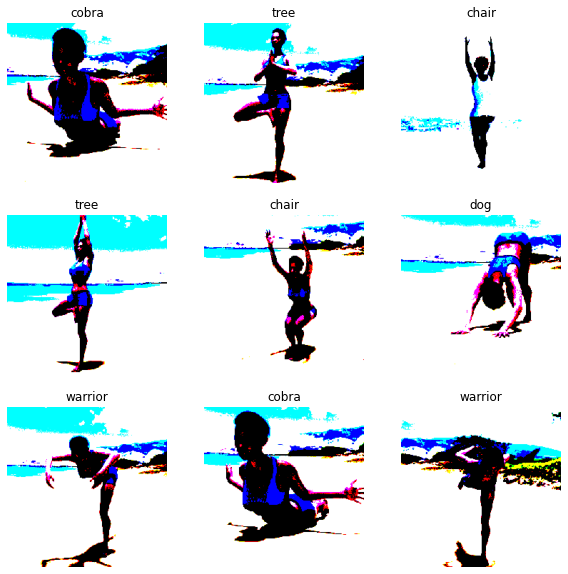

In [5]:
## visualize validation images 
image_batch, label_batch = next(iter(val_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")

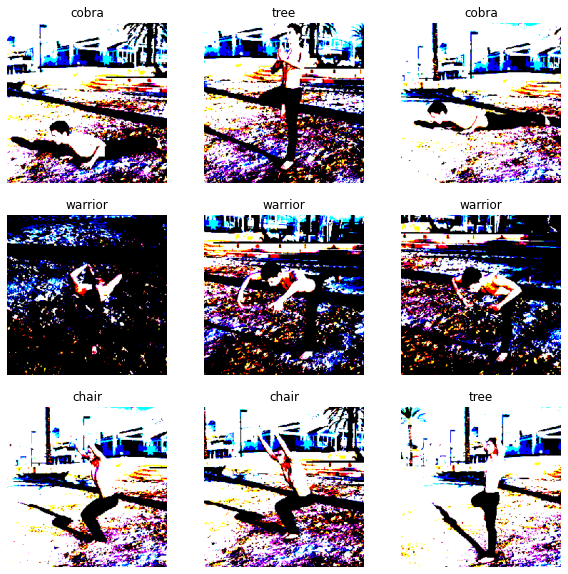

In [6]:
## visualize test images 
image_batch, label_batch = next(iter(test_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")

2022-02-18 09:22:31.658431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 09:22:31.756274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 09:22:31.757118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 09:22:31.758524: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

CPU times: user 37.6 s, sys: 3.34 s, total: 40.9 s
Wall time: 52.6 s
16/16 [==============================] - 4s 287ms/step - loss: 9.6126 - accuracy: 0.2202
Test image accuracy :0.2202020138502121


2022-02-18 09:23:33.839046: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Classification Report for new test images 
              precision    recall  f1-score   support

       chair       0.00      0.00      0.00        76
       cobra       0.31      0.24      0.27       111
         dog       0.00      0.00      0.00        81
        tree       0.09      0.01      0.02        92
     warrior       0.22      0.71      0.34       103

    accuracy                           0.22       463
   macro avg       0.12      0.19      0.13       463
weighted avg       0.14      0.22      0.14       463

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 8)    

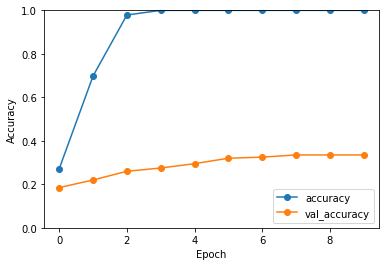

In [7]:
## two layer CNN with lesser filter 8, 8

##
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 8, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
     tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 8, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),   
  tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(5, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_ds, epochs=10, validation_data = val_ds, verbose = 0)
##
test_loss, test_acc = model.evaluate(test_ds)
print("Test image accuracy :{}".format(test_acc))
##
pred= model.predict(test_ds)
##
predicted_class_indices=np.argmax(pred,axis=1)
##
labels = (train_ds.class_indices)
labels_dict = dict((v,k) for k,v in labels.items())
predictions = [labels_dict[k] for k in predicted_class_indices]
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn2')
##
loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##
print(model.summary())
##


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
_________________________________________________________________
CPU times: user 3min 31s, sys: 13 s, total: 3min 44s
Wall time: 3min 45s
25/25 [==============================] - 2s 83ms/step - loss: 1.6824 - accuracy: 0.7071
Test image accuracy :0.7070707082748413
Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.20      0.33        82
       cobra 

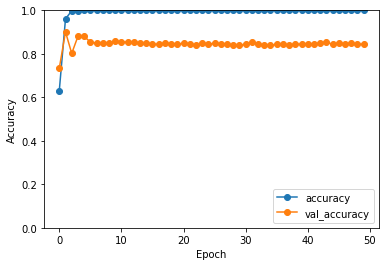

In [9]:
## Transfer learning with VGG16 . 
base_Net = tf.keras.applications.VGG16(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1024))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , steps_per_epoch=STEP_SIZE_TRAIN ,  validation_data = val_ds, validation_steps=STEP_SIZE_VALID , epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds , steps=STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_vgg16_1')

loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 5125      
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
_________________________________________________________________
CPU times: user 3min 17s, sys: 10.9 s, total: 3min 28s
Wall time: 3min 33s
25/25 [==============================] - 2s 79ms/step - loss: 0.7280 - accuracy: 0.7818
Test image accuracy :0.7818182110786438
Classification Report for new t

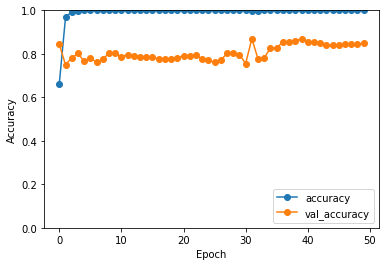

In [10]:
## Transfer learning with VGG16 . With drop out 
base_Net = tf.keras.applications.VGG16(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1024))
model_Net.add(tf.keras.layers.Dropout(0.2))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , steps_per_epoch=STEP_SIZE_TRAIN ,  validation_data = val_ds, validation_steps=STEP_SIZE_VALID , epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds,  steps=STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_vgg16_2')

## for test data set , check the classification report.
loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##
model_Net.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________
CPU times: user 3min 15s, sys: 11.3 s, total: 3min 26s
Wall time: 3min 29s
25/25 [==============================] - 2s 95ms/step - loss: 0.6251 - accuracy: 0.8586
Test image accuracy :0.8585858345031738
Classification Report for new test images 
              precision    recall  f1-score   support

       chair       0.94      0.64      0.77        76
       cobr

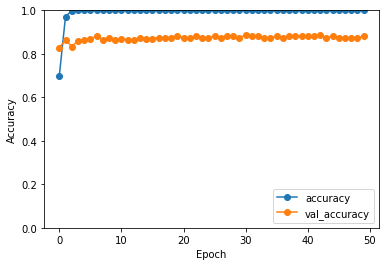

In [11]:
## Transfer learning with VGG16 . with 512 neurons
base_Net = tf.keras.applications.VGG16(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(512))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , steps_per_epoch=STEP_SIZE_TRAIN ,  validation_data = val_ds, validation_steps=STEP_SIZE_VALID , epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds, steps = STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model.save('model_vgg16_3')

## for test data set , check the classification report.
loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##
print(model_Net.summary())

#### Test model on new images of yoga pose. 

In [12]:
## read in all the new test yoga poses and check the prediction 

test_path_2 = "../input/new-yoga-poses/yoga_test_data"
test_ds_2 = test_data_gen.flow_from_directory(test_path_2 ,target_size=(224, 224),
        batch_size=32 ,class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')


Found 26 images belonging to 5 classes.


In [13]:
## load the model 
model = tf.keras.models.load_model('./model_vgg16_3')
##

loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       0.00      0.00      0.00         6
       cobra       0.00      0.00      0.00         5
         dog       0.00      0.00      0.00         5
        tree       1.00      0.60      0.75         5
     warrior       0.33      0.20      0.25         5

    accuracy                           0.15        26
   macro avg       0.27      0.16      0.20        26
weighted avg       0.26      0.15      0.19        26



In [16]:
## load the model 
model = tf.keras.models.load_model('./model_vgg16_1')
##

loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.17      0.29         6
       cobra       0.67      0.40      0.50         5
         dog       1.00      0.60      0.75         5
        tree       0.36      0.80      0.50         5
     warrior       0.25      0.40      0.31         5

    accuracy                           0.46        26
   macro avg       0.66      0.47      0.47        26
weighted avg       0.67      0.46      0.46        26



In [17]:
## load the model 
model = tf.keras.models.load_model('./model_vgg16_2')
##

loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       0.50      0.17      0.25         6
       cobra       0.67      0.40      0.50         5
         dog       0.71      1.00      0.83         5
        tree       0.42      1.00      0.59         5
     warrior       0.50      0.20      0.29         5

    accuracy                           0.54        26
   macro avg       0.56      0.55      0.49        26
weighted avg       0.56      0.54      0.48        26



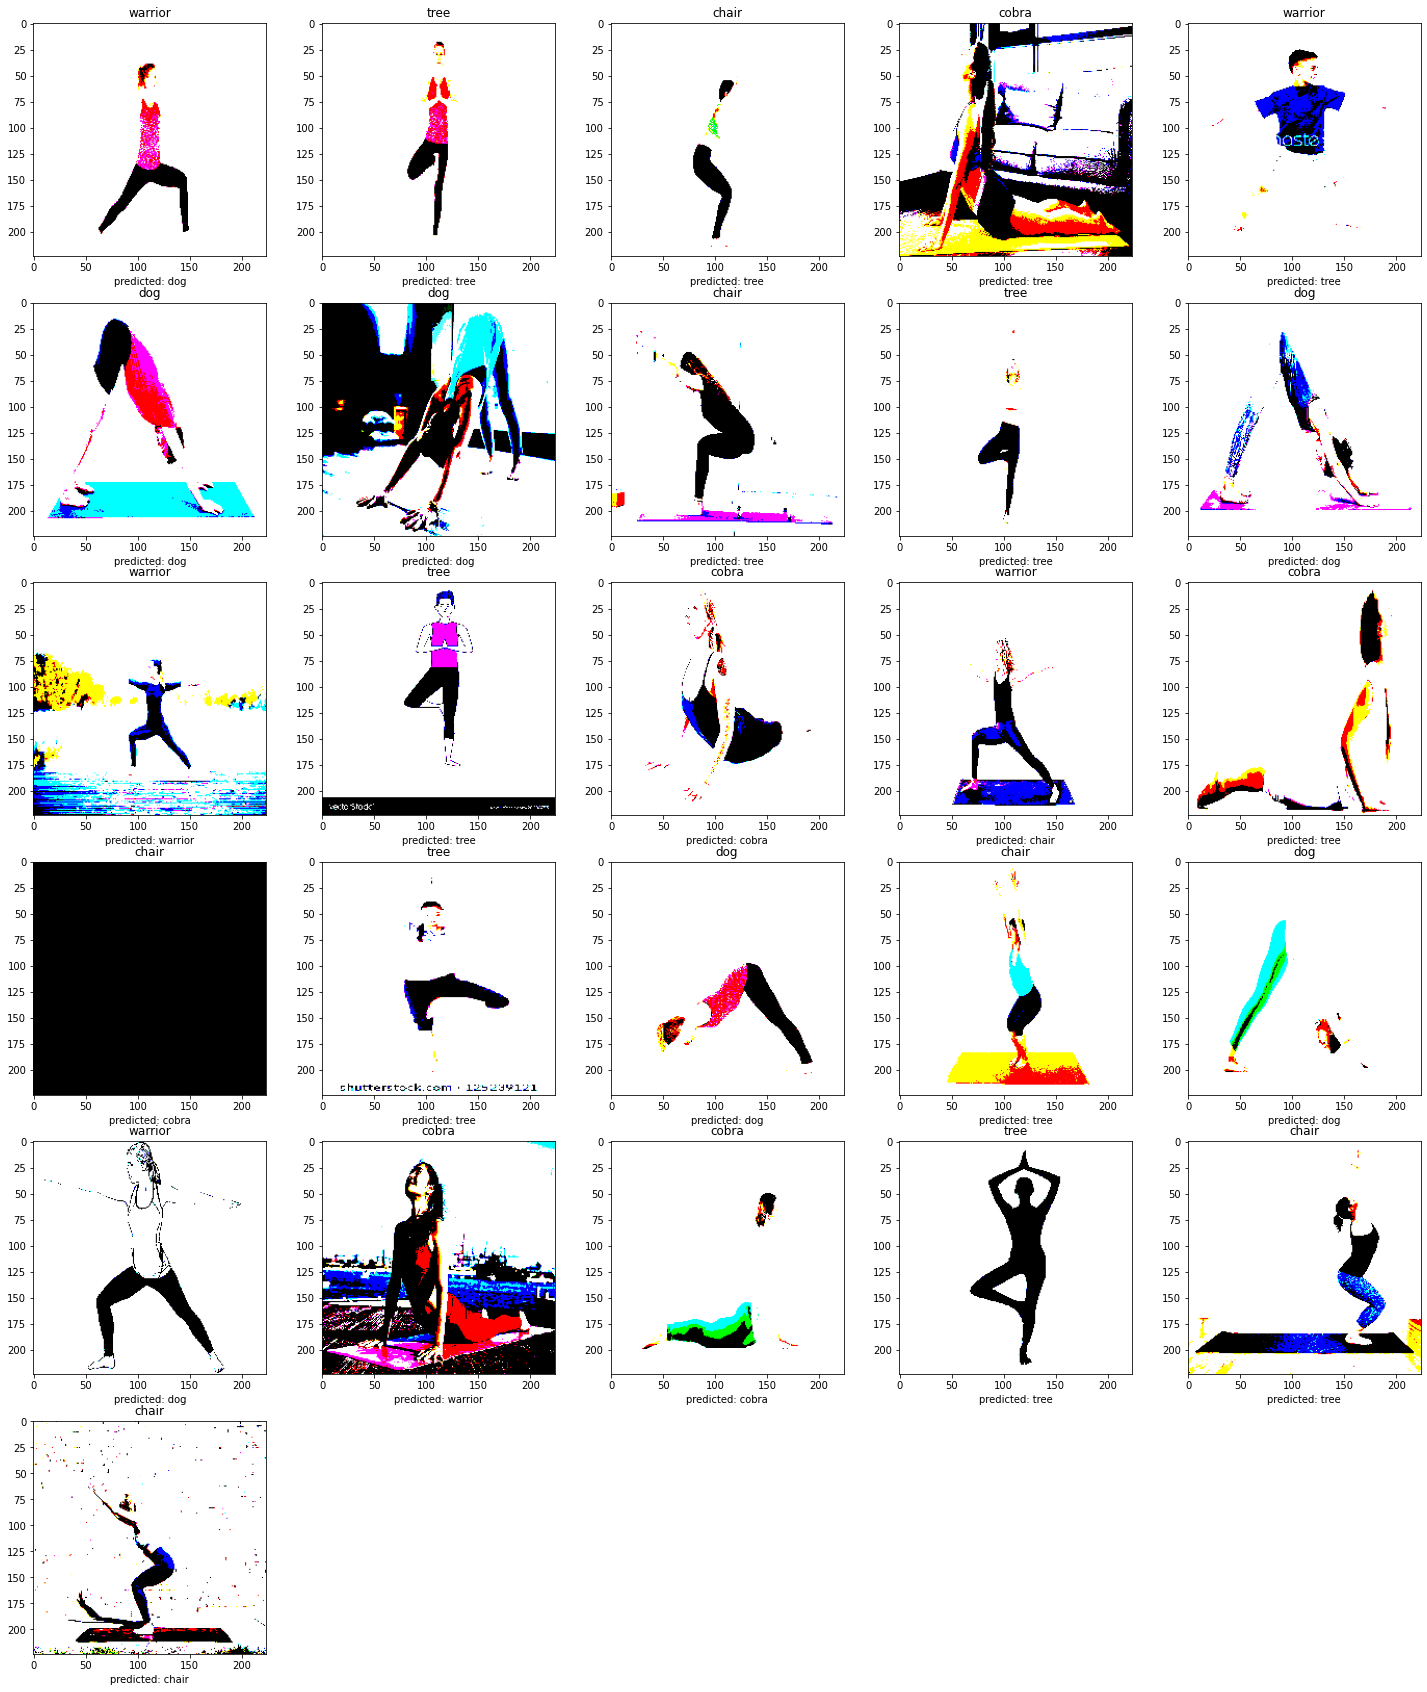

In [19]:
## visualize images with their prediction 
image_batch, label_batch = test_ds_2.next()
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(25, 30))
for i in range(26):
    ax = plt.subplot(6, 5, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(img[0][i], cv2.COLOR_BGR2RGB))
    label = actual[i]
    pred_label = predicted[i]
    name = labels_dict[label]
    plt.title(name)
    plt.xlabel('predicted: ' + labels_dict[pred_label])
    #plt.axis("off")

Summary :

Transfer learning with VGG16  gives best test image accuracy of 0.77. On the new images downloaded from the internet , which consists of non CGI origin , the accuracy is 0.54.